In [ ]:
!ls

In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv('steps_train.txt', skiprows=1,nrows=110, header=None, usecols=[1,2])

In [3]:
len(df)

110

In [4]:
import matplotlib.pyplot as plt

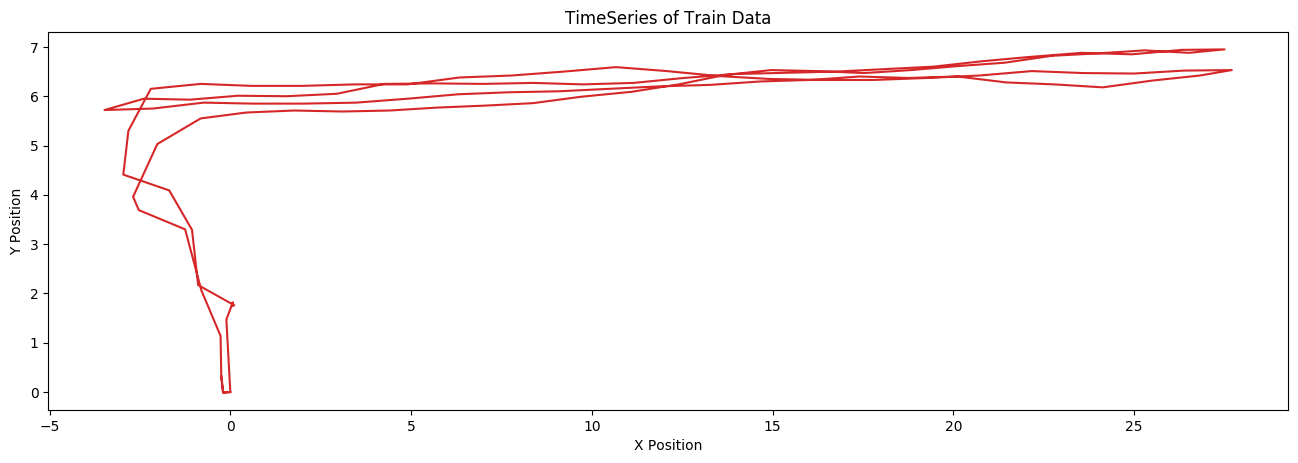

In [5]:
# Draw Plot
def plot_df(df, x, y, title="TimeSeries", xlabel='X Position', ylabel='Y Position', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df[1], y=df[2], title='TimeSeries of Train Data') 

In [18]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel, eigh
from matplotlib import pyplot as plt
from matplotlib import style

In [21]:
N = len(df[1])
L = (N)//2
d1 = hankel(df[1][:L], hankel(df[1][L-1:]))
d2 = hankel(df[2][:L], hankel(df[2][L-1:]))

In [22]:
d1.shape

(55, 3136)

In [23]:
d2.shape

(55, 3136)

In [24]:
X_train = np.hstack((d1,d2))

In [25]:
# X_train = hankel(X_train_data[:L],X_train_data[L-1:]) # Creating trajectory matrix

In [26]:
X_train.shape

(55, 6272)

Text(0.5, 0, 'Cardinal Number of Eigen value ->')

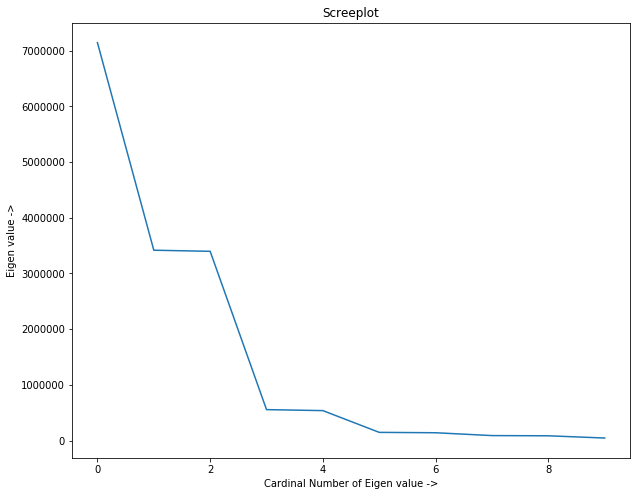

In [28]:
eigenValues, eigenVectors = eigh(np.matmul(X_train, X_train.T))
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
# Sree plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(eigenValues[0:10])
ax.set_title("Screeplot")
ax.set_ylabel("Eigen value ->")
ax.set_xlabel("Cardinal Number of Eigen value ->")

In [29]:
# From the above scree plot, it is seen that the first eigen value is more 
# significant and the other eigen values are close to zero. Thus we choose r as 1
# and then we compute the U for projection and centroid in the signal subspace
r = 4
# Extracted Training signals
U, Sigma, V = np.linalg.svd(X_train)
V = V.T
# d = np.linalg.matrix_rank(X_train)
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,r)] )
X_train_extracted = X_elem.sum(axis=0)
X_train_extracted_data = np.asarray(list(X_train_extracted[:,0]) + list(X_train_extracted[:,-1]))

U = eigenVectors[:,:r] # r as statistical dimension
UT = U.T
pX = np.matmul(UT,X_train_extracted)
centroid = np.mean(pX, axis=1)
centroid = centroid[:,np.newaxis]

In [30]:
X_train_extracted.shape

(55, 6272)

In [31]:
# Calculating the departure threshold in signal subspace using centroid and UT

# #For training phase
# Xtrg = hankel(X_train_data[:L], X_train_data[L-1:])
# pXtrg = np.matmul(UT,Xtrg)
# dtrg_matrix = centroid - pXtrg
# dtrg_scores = np.linalg.norm(dtrg_matrix, axis=0, ord=2)

# For Validation phase and threshold calculation
# Xt = hankel(X_train_data[:L],X_train_data[L-1:])
pXt = np.matmul(UT,X_train)
dt_matrix = centroid - pXt
dt_scores = np.linalg.norm(dt_matrix, axis=0, ord=2)
# d_scores = np.asarray([np.matmul(d_matrix[:,i].T, d_matrix[:,i]) for i in range(d_matrix.shape[1])])
np.max(dt_scores)


108.3375154977311

In [32]:
np.min(dt_scores)

18.27729198170754

In [33]:
range(len(dt_scores))

range(0, 6272)

In [34]:
# Import data
# df = pd.read_csv('datasets/AirPassengers.csv', parse_dates=['date'])
def PlotThresholdArea(y1, title='Threshold Area'):
    x = range(len(y1))
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(-100, 100)
    plt.title(title, fontsize=16)
    plt.hlines(y=0, xmin=np.min(x), xmax=np.max(x), linewidth=.5)
    plt.show()

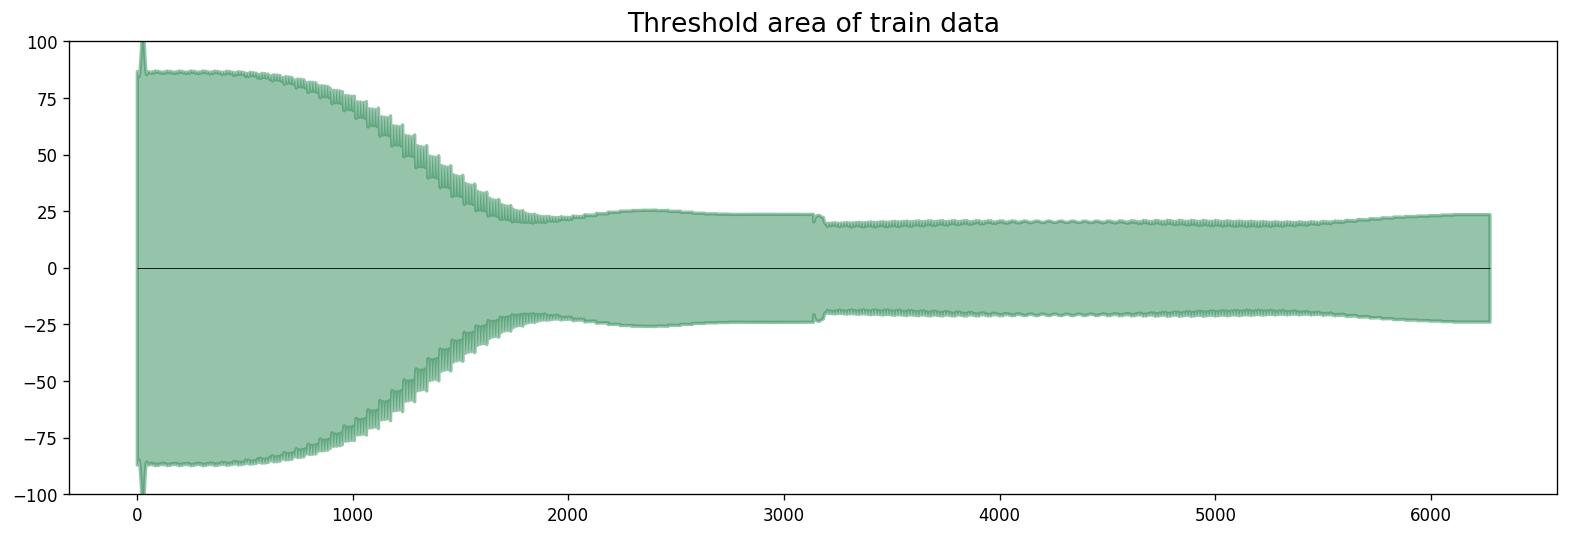

In [35]:
PlotThresholdArea(dt_scores, title='Threshold area of train data')

### Testing positional Deviation

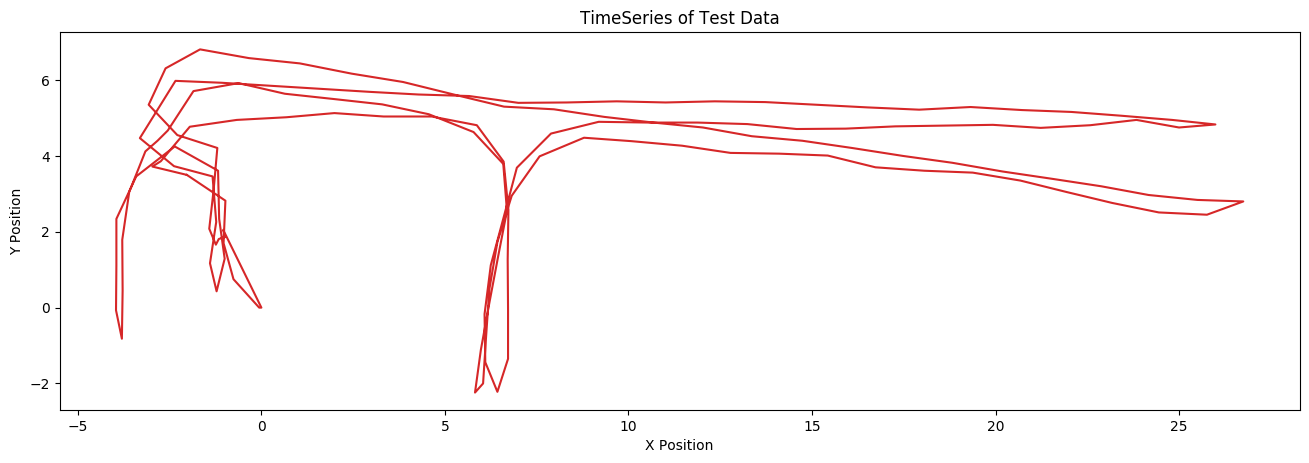

In [47]:
df_test = pd.read_csv('steps_test.txt', skiprows=1, nrows=150, header=None, usecols=[1,2])
plot_df(df, x=df_test[1], y=df_test[2], title='TimeSeries of Test Data') 

In [48]:
len(df_test)

150

In [49]:
# X_test = (df_test[1]+df_test[2])/2


In [50]:
d3 = hankel(df_test[1][:L], hankel(df_test[1][L-1:]))
d4 = hankel(df_test[2][:L], hankel(df_test[2][L-1:]))
Xj = np.hstack((d3,d4))

In [51]:
Xj.shape

(55, 18432)

In [52]:
# Xj = hankel(X_test[:L],X_test[L-1:])
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
# dj_scores = [np.matmul(dj_matrix[:,i].T, dj_matrix[:,i]) for i in range(dj_matrix.shape[1])]
dj_scores = np.asarray(dj_scores)
np.max(dj_scores)

83.94153232915194

In [53]:
len(dj_scores)

18432

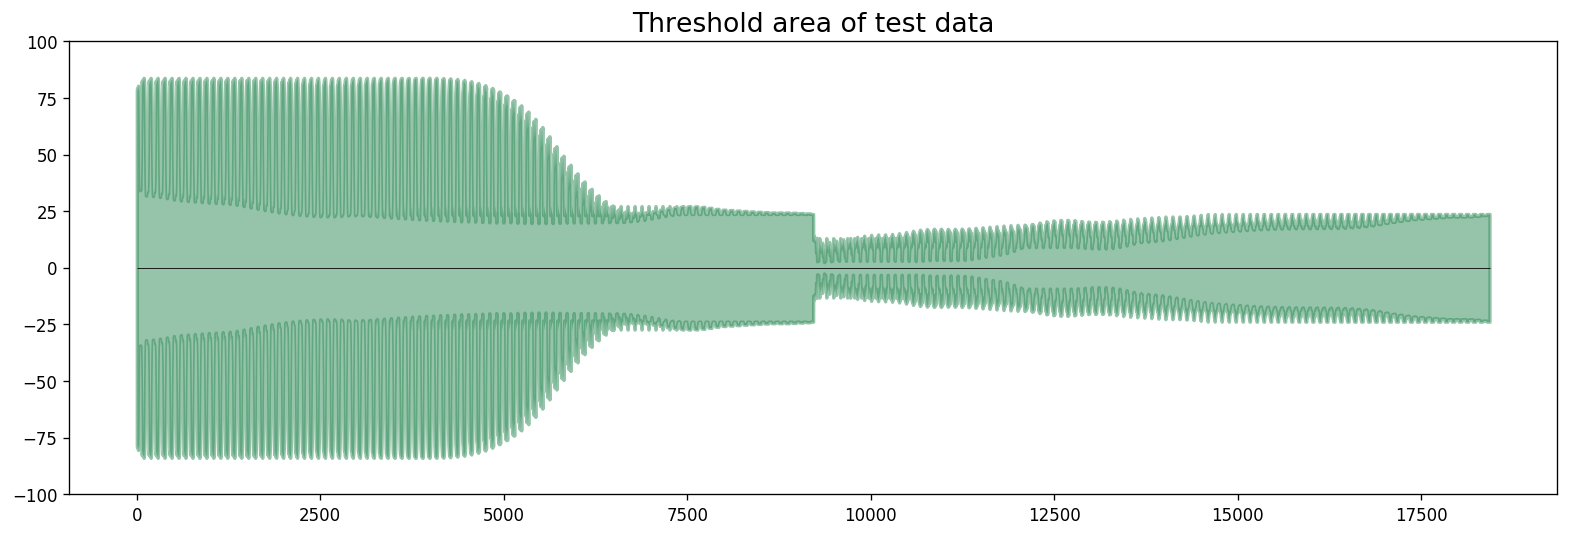

In [54]:
PlotThresholdArea(dj_scores, title='Threshold area of test data')

In [28]:
import plotly.graph_objects as go

In [29]:
train_scores = go.Scatter(x=list(range(len(dt_scores))), y=dt_scores)
test_scores = go.Scatter(x=list(range(len(dj_scores))), y=dj_scores)
layout = go.Layout()

In [30]:
fig=go.Figure(data=[train_scores, test_scores], layout=layout)

In [31]:
fig.show()

### Test for stationarity


In [ ]:
df_test = pd.read_csv('steps_stationarity.txt', skiprows=1, header=None, usecols=[1,2])
plot_df(df, x=df_test[1], y=df_test[2], title='TimeSeries of Test Data')

In [ ]:
X_test = (df_test[1]+df_test[2])/2
Xj = hankel(X_test[:L],X_test[L-1:])
pXj = np.matmul(UT, Xj)
dj_matrix = centroid - pXj
dj_scores = np.linalg.norm(dj_matrix, axis=0, ord=2)
# dj_scores = [np.matmul(dj_matrix[:,i].T, dj_matrix[:,i]) for i in range(dj_matrix.shape[1])]
dj_scores = np.asarray(dj_scores)
np.max(dj_scores)

In [ ]:
PlotThresholdArea(dj_scores, title='Threshold area of test data')